# **🌤️ Sky/Cloud Segmentation Using Superpixels**

In [1]:
import sys
sys.path.append('../')

from typing import List

import os
import umap
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import torch

DATA_PATH = '../data/'
SCS_DATA_PATH = DATA_PATH + 'sky_cloud_segmentation/'

SKY_FINDER_PATH = SCS_DATA_PATH + "sky_finder/"
SKY_FINDER_INPUTS_PATH = SKY_FINDER_PATH + "images/"
SKY_FINDER_MASKS_PATH = SKY_FINDER_PATH + "masks/"

IMAGE_HEIGHT, IMAGE_WIDTH = 480, 640

MEAN = [174.07300672, 186.89331792, 196.85514]
STD = [51.88691547, 43.47123826, 40.3533195]

c:\Users\arnau\anaconda3\envs\semester_project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SCRandomPatchesDataset(torch.utils.data.Dataset):
    """
    Dataset of random patches from sky/cloud images.
    
    Args:
        input_paths: List of paths to input images.
        mask_paths: List of paths to mask images.
        patch_size: Size of patches.
        n_patches: Number of patches to generate.
        
    Returns:
        torch.utils.data.Dataset: Dataset of random patches.
    """

    def get_patches(
            self, 
            input_paths: List[str],
            mask_paths: List[str],
            image_height: int,
            image_width: int,
            patch_size: int, 
            n_patches: int, 
            n_tries: int = 10
            ) -> List[np.ndarray]:
        """
        Get random patches from images.
        
        Args:
            input_paths: List of paths to input images.
            mask_paths: List of paths to mask images.
            patch_size: Size of patches.
            n_patches: Number of patches to generate.
            n_tries: Number of tries to generate a patch.
            
        Returns:
            List[torch.Tensor]: List of patches.
        """

        assert n_patches > 0, f"❌ Number of patches must be positive: {n_patches}"
        assert patch_size % 2 == 1, f"❌ Patch size must be odd: {patch_size}"

        patches = []
        padding = patch_size // 2
        bar = tqdm(total=n_patches, desc="Generating patches")
        while len(patches) < n_patches:
            image_idx = np.random.randint(0, len(input_paths))
            try:
                # Get image and mask
                image = np.array(Image.open(input_paths[image_idx]).resize((image_width, image_height)))
                mask = np.array(Image.open(mask_paths[image_idx]).convert("L").resize((image_width, image_height)))
            except Exception as e:
                print(f"❌ Error loading images: {e}")
                continue

            # Binarize mask
            mask = mask > 128

            # Add padding to image and mask
            image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode="reflect")
            mask = np.pad(mask, ((padding, padding), (padding, padding)), mode="reflect")

            patch = None
            tries = 0
            while patch is None and tries < n_tries:
                # Get random patch from (x, y) center coordinates
                x = np.random.randint(padding, image_width + padding)
                y = np.random.randint(padding, image_height + padding)
                image_patch = image[y-padding:y+padding+1, x-padding:x+padding+1]

                # If the center pixel of the patch is not sky, skip
                if mask[y, x] == False:
                    tries += 1
                    continue

                patch = image_patch

                # Normalize patch
                patch = (patch - MEAN) / STD

            # Add patch only if it was found
            if patch is None:
                continue

            patches.append(patch)
            bar.update(1)

        return np.array(patches)

    def __init__(
            self, 
            input_paths: List[str], 
            mask_paths: List[str], 
            image_height: int = 480,
            image_width: int = 640,
            patch_size: int = 25, 
            n_patches: int = 1000
            ):
        self.patches = self.get_patches(input_paths, mask_paths, image_height, image_width, patch_size, n_patches)

        print(f"✅ Created dataset of {len(self.patches)} patches.")

    def get_mean_std(self):
        """
        Get mean and standard deviation of dataset channels.
        
        Returns:
            Tuple[float, float]: Mean and standard deviation of dataset.
        """

        patches = np.array(self.patches)
        return patches.mean(axis=(0, 1, 2)), patches.std(axis=(0, 1, 2))

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        return self.patches[idx]

input_paths = []
mask_paths = []

# Sky Finder
input_folder_paths = sorted([os.path.join(SKY_FINDER_INPUTS_PATH, folder) for folder in os.listdir(SKY_FINDER_INPUTS_PATH)])
for folder_path in input_folder_paths:
    image_paths = sorted([os.path.join(folder_path, filename) for filename in os.listdir(folder_path)])
    for image_path in image_paths:
        input_paths.append(image_path)
        mask_paths.append(os.path.join(SKY_FINDER_MASKS_PATH, folder_path.split("/")[-1] + ".png"))
assert len(input_paths) == len(mask_paths)

dataset = SCRandomPatchesDataset(
    input_paths=input_paths,
    mask_paths=mask_paths,
    patch_size=25,
    image_height=IMAGE_HEIGHT,
    image_width=IMAGE_WIDTH,
    n_patches=10000
)

Generating patches: 100%|██████████| 10000/10000 [01:14<00:00, 134.01it/s]

✅ Created dataset of 10000 patches.


In [3]:
# Get mean and standard deviation
# mean, std = dataset.get_mean_std()
# print(f"Mean: {mean}, Std: {std}")

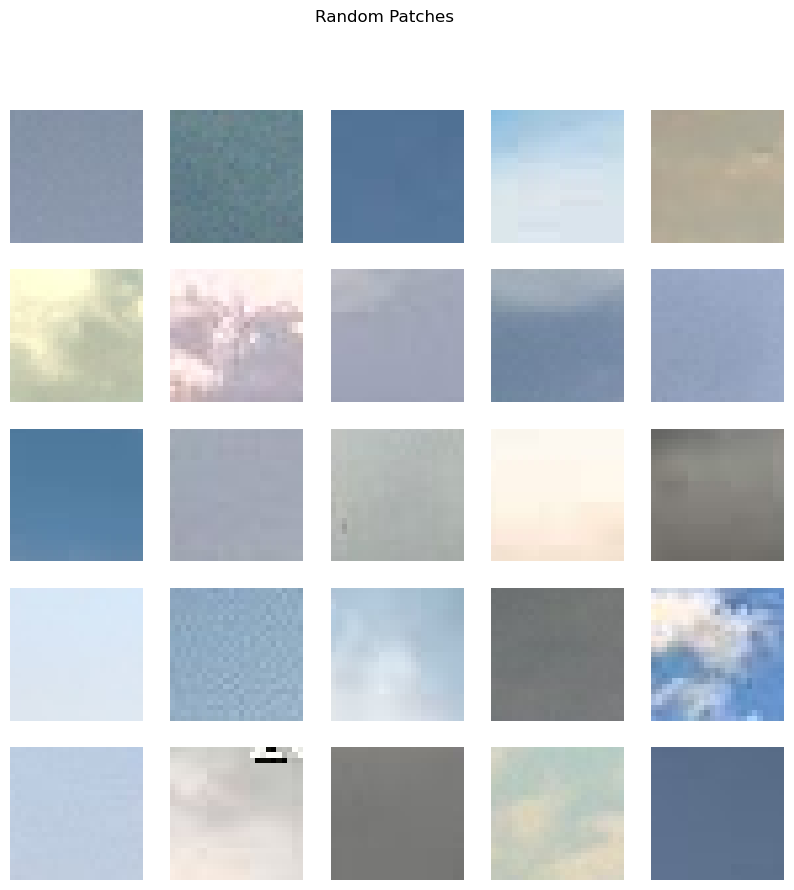

In [4]:
# Show some patches
def show_patches(dataset, width: int = 5, height: int = 5):
    """
    Show patches from dataset.
    
    Args:
        dataset: Dataset of patches.
        width: Width of plot.
        height: Height of plot.
    """

    assert width > 0, f"❌ Width must be positive: {width}"
    assert height > 0, f"❌ Height must be positive: {height}"

    _, axs = plt.subplots(height, width, figsize=(width*2, height*2))
    for i in range(height):
        for j in range(width):
            patch = dataset[i*width + j]

            # Undo normalization
            patch = patch * STD + MEAN
            patch = np.clip(patch, 0, 255).astype(np.uint8)

            axs[i, j].imshow(patch)
            axs[i, j].axis('off')

    plt.suptitle("Random Patches")
    plt.show()

show_patches(dataset)

In [5]:
# Get tensor of patches
X = torch.tensor(np.array(dataset.patches)).reshape(-1, 3*25*25)
X.shape

torch.Size([10000, 1875])

100%|██████████| 99/99 [01:50<00:00,  1.12s/it]


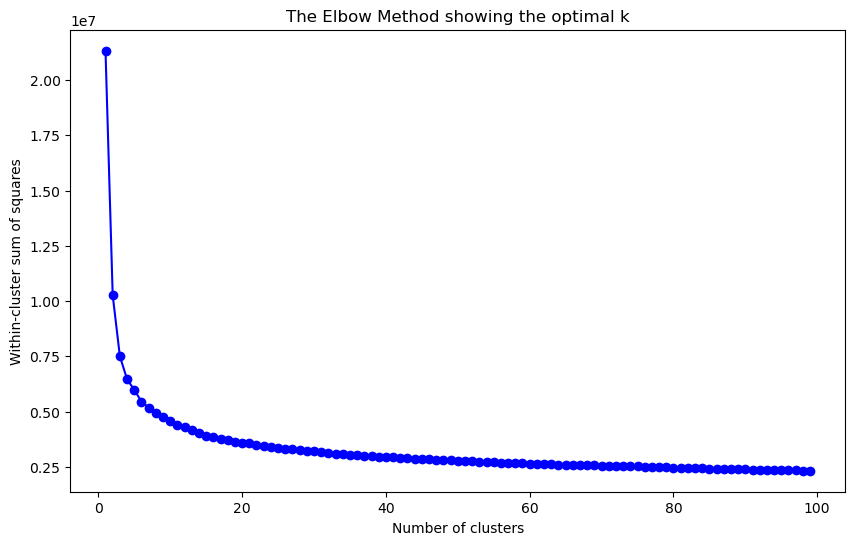

In [33]:
def show_elbow(X: torch.Tensor):
    wss = []
    K_range = range(1,100)  # Change the range as needed
    for k in tqdm(K_range):
        kmeans = KMeans(n_clusters=k, random_state=0, n_init='auto').fit(X)
        wss.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

    plt.figure(figsize=(10,6))
    plt.plot(K_range, wss, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Within-cluster sum of squares')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

show_elbow(X)

In [41]:
# Apply k-means to get BOW
kmeans = KMeans(n_clusters=40, random_state=0, n_init='auto').fit(X)
cluster_labels = kmeans.labels_

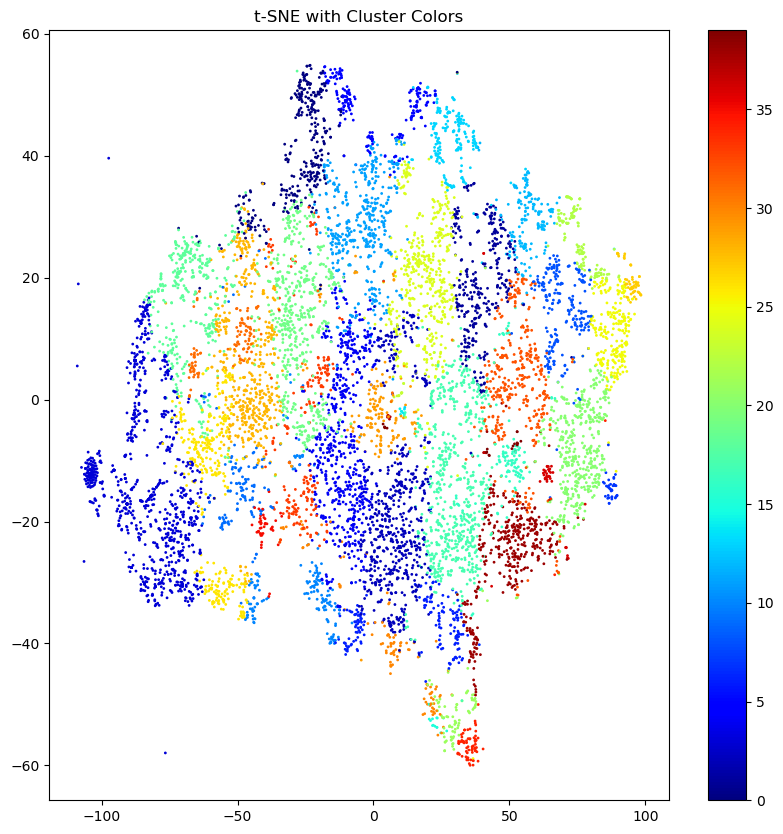

In [42]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE with cluster colors
def plot_tsne_with_clusters(X_tsne, cluster_labels, title="t-SNE with Cluster Colors"):
    plt.figure(figsize=(10, 10))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='jet', s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_tsne_with_clusters(X_tsne, cluster_labels)

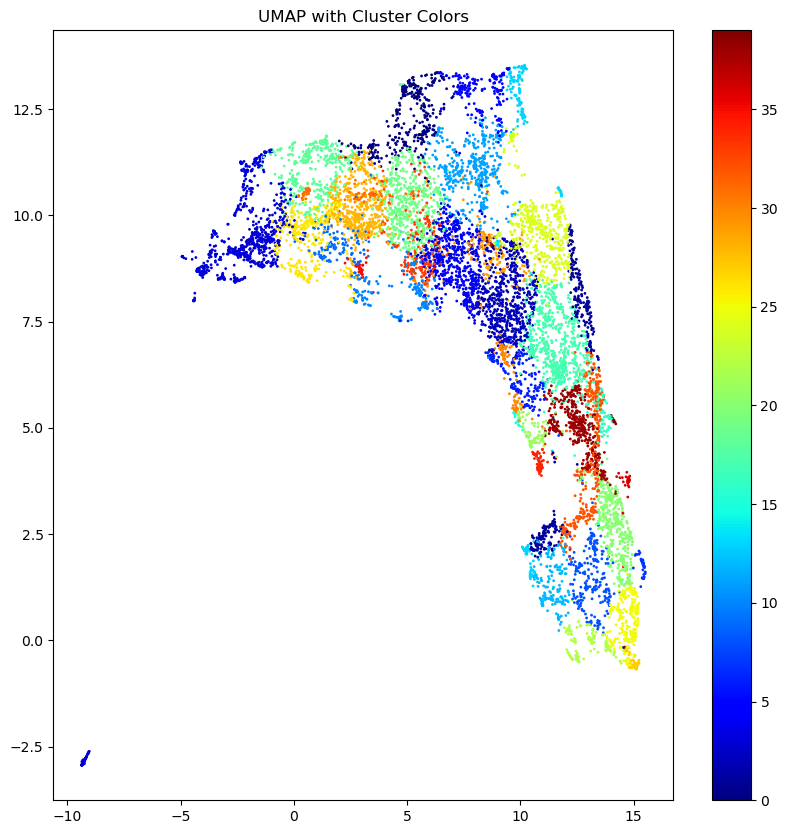

In [43]:
# Apply UMAP
reducer = umap.UMAP()
X_umap = reducer.fit_transform(X)

# Plot UMAP with cluster colors
def plot_umap_with_clusters(X_umap, cluster_labels, title="UMAP with Cluster Colors"):
    plt.figure(figsize=(10, 10))
    plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='jet', s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

plot_umap_with_clusters(X_umap, cluster_labels)

In [44]:
from sklearn.metrics import pairwise_distances_argmin_min

def get_cluster_indices(image, kmeans, patch_size=25):

    # Add padding to image
    padding = patch_size // 2
    image = np.pad(image, ((padding, padding), (padding, padding), (0, 0)), mode="reflect")

    # Extract patches with a stride of 1
    patches = [image[y-padding:y+padding+1, x-padding:x+padding+1] for y in range(padding, image.shape[0] - padding) for x in range(padding, image.shape[1] - padding)]

    # Normalize patches
    patches = [(patch - MEAN) / STD for patch in patches]

    # Get patch as feature vector
    patches_features = np.array([patch.reshape(-1) for patch in patches])

    # Assign each patch to the nearest cluster
    cluster_indices, _ = pairwise_distances_argmin_min(patches_features, kmeans.cluster_centers_)

    return cluster_indices

def show_bow_assignments(image, kmeans, patch_size=25):
    cluster_indices = get_cluster_indices(image, kmeans, patch_size)
    cluster_image = cluster_indices.reshape(image.shape[0], image.shape[1])

    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(cluster_image, cmap='jet')
    plt.colorbar()
    plt.title("BOW Assignments")
    plt.show()

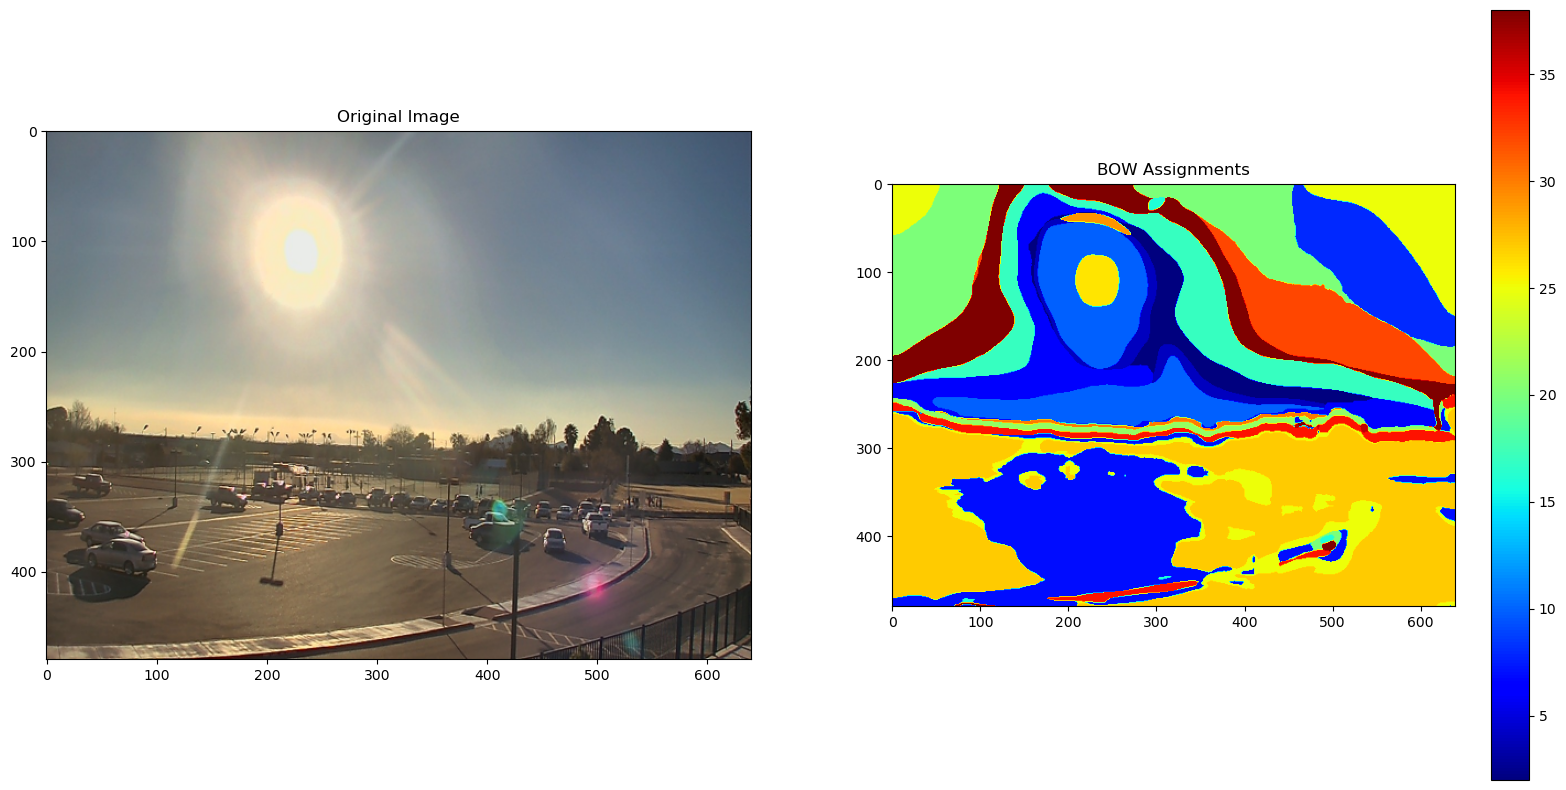

In [45]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20130205_000309.jpg'
image_example = np.array(Image.open(image_example_path).resize((640, 480)))
show_bow_assignments(image_example, kmeans)

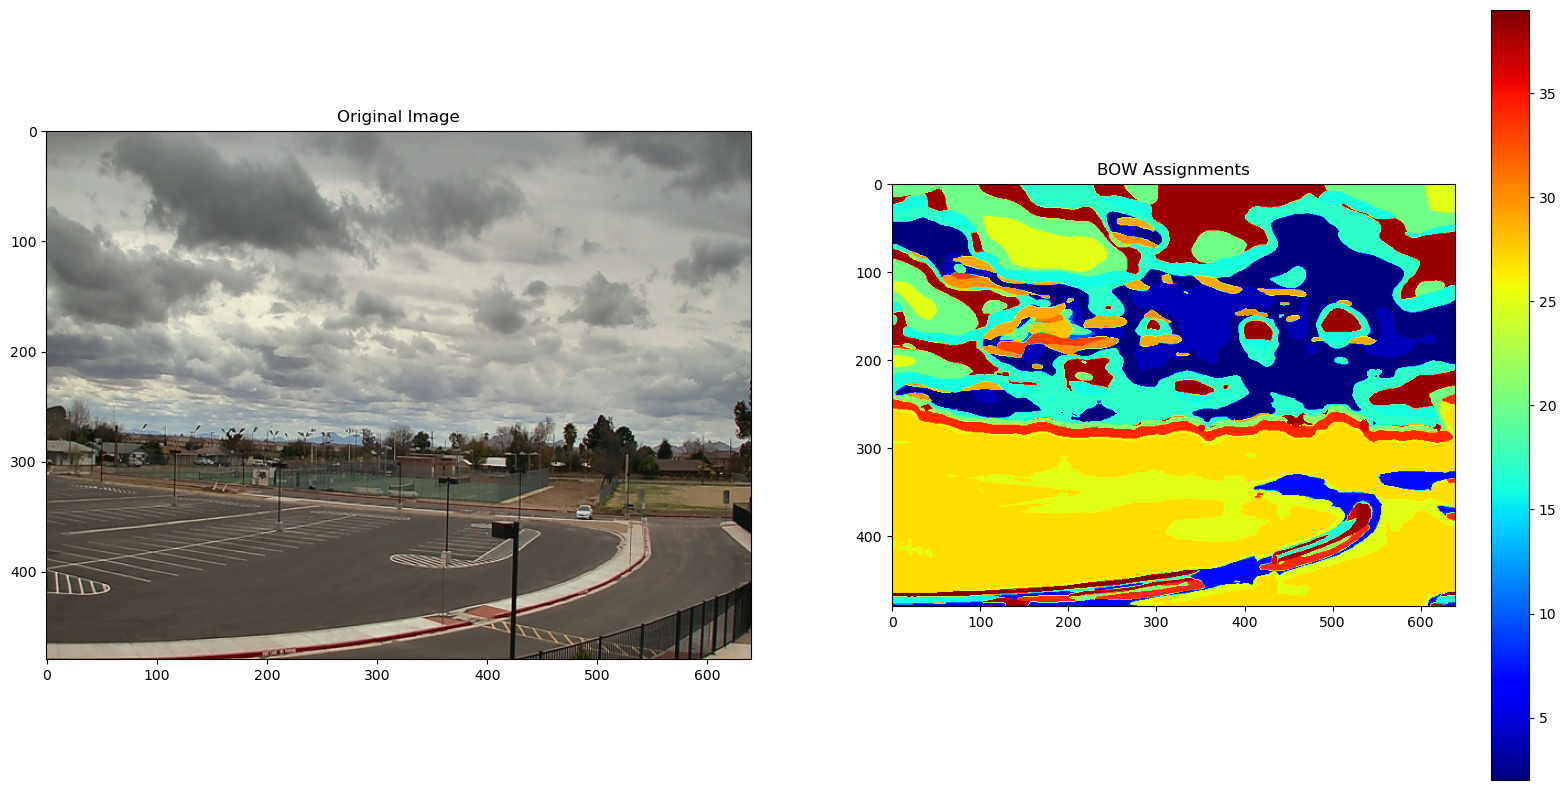

In [46]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20130309_193305.jpg'
image_example = np.array(Image.open(image_example_path).resize((640, 480)))
show_bow_assignments(image_example, kmeans)

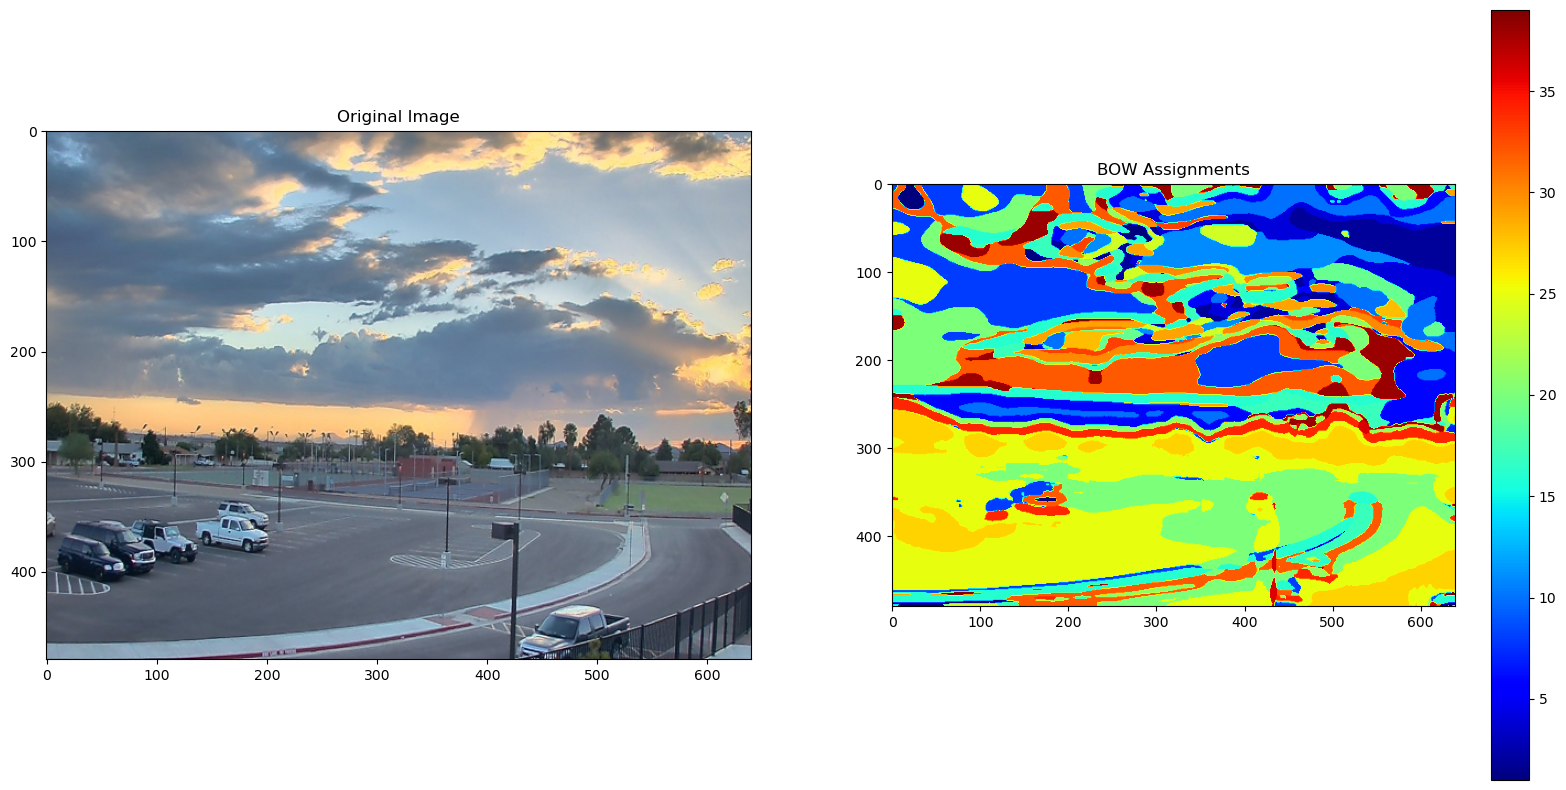

In [47]:
image_example_path = SKY_FINDER_INPUTS_PATH + '65/20140820_020310.jpg'
image_example = np.array(Image.open(image_example_path).resize((640, 480)))
show_bow_assignments(image_example, kmeans)